# simplest tests for screening via density dependence of attraction coefficients
Tim Tyree<br>
11.30.2021

In [1]:
from lib.my_initialization import *
# from lib.controller.controller_LR import get_one_step_explicit_synchronous_splitting
# from lib.utils import load_buffer
# from lib.routines.return_min_distance import *
# from lib.viewer.DomainPlot import ShowDomain
# from lib.measure.comp_tips_safely import *
from lib import *

#my_initialization.py
import pandas as pd, numpy as np, matplotlib.pyplot as plt

#load the libraries
# from .utils.operari import *
#automate the boring stuff
# from IPython import utils
import time, os, sys, re
import dask.bag as db
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()

#radial neighbor velocities
from lib.routines.compute_dRdt_in_bulk import *
from lib.routines import compute_dRdt_in_bulk
from lib.utils.utils_traj import get_DT
    
#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

Automatic calling is: Smart


# define alignment module

In [50]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float,axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#TODO: port to lib:
#this block tares ballistically annihilating particles
#TODO: accelerate tshift_tare_routine
#NOTA BENE: the same memory, df_Ri, is being accessed by every worker simultaneously...
#TODO: compare runtimes with cudf.DataFrame(df_Ri)
def tshift_tare_routine(df_R,navg2,max_num_groups=9e9,npartitions=None,R_col='R_nosavgol',printing=True,**kwargs):
    '''
    Nota Bene: the same memory, df_Ri, is being accessed by every worker simultaneously...

    Example Usage:
    retval=tshift_tare_routine(df_R,navg2,max_num_groups=9e9,plotting=False,npartitions=None,R_col='R_nosavgol')
    tshift_align_lst,speed_align_lst,group_name_lst,SR_speed_align_lst,Delta_SR_speed_align_lst=retval
    '''
    navg2=navg2 if navg2%2==1 else navg2+1
    #TODO: accelerate tshift_tare_routine
    #compute time shifts for the first x groups
    #include memory preallocation 
    df_R['tdeath_align']=df_R['tdeath'].copy()
    #sort by time
    df_R.sort_values(by='tdeath',ascending=True,inplace=True)
    #group dataframe by annihilation event
    # groups=df_R.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
    groups=df_R.groupby(['event_id_int','pid_self','pid_other'])
    df_Ri=df_R.set_index(['event_id_int','pid_self','pid_other'])
    # groups=df_fk.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
    tshift_align_lst=[]
    speed_align_lst=[]
    group_name_lst=[]
    SR_speed_align_lst=[]
    Delta_SR_speed_align_lst=[]
    count=0
    task_lst=[]
    for group_name,g in groups:
        count+=1
        if max_num_groups>=count:
            data=group_name,g
            #TODO: generate task_lst
            task_lst.append(data)
    
    #DONE: accelerate tshift_tare_routine here
    def eval_routine(data):
        mode='diff'#'ols'
        group_name,g=data
        #to compute tshift_align,
        savgol_kwargs=dict(
                window_length=navg2,
                polyorder=3,
                deriv=1,
                delta=1.0,
                axis=-1,
                mode='interp')
        savgol0_kwargs=dict(
                window_length=navg2,
                polyorder=3,
                deriv=0,
                delta=1.0,
                axis=-1,
                mode='interp')

        #extract the R_values and tdeath_values
        tdeath_values=g['tdeath'].values
        SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
        #perform ols least squares on the final 8 values
        if mode=='ols':  
            y=SR_values[:8]
            x=tdeath_values[:8]
        else:# mode=='diff':
            y=SR_values[:3]
            x=tdeath_values[:3]
            
        dict_ols=compute_95CI_ols(x,y)
        m=dict_ols['m']
        SR_speed_align=m
        Delta_SR_speed_align=dict_ols['Delta_m']
        #compute the time shift
        tf=x[0]
        tshift_align=float(tf+dict_ols['b']/m)
#         else:
#             SR_speed_align=-9999
#             Delta_SR_speed_align=-9999
#             tshift_align=-9999
#             #raise(r'Exception: mode={mode} not implemented!')
        #compute tdeath_align from tdeath and the moving average of speed
        #tshift trajectories by that value
        return tshift_align,group_name,SR_speed_align,Delta_SR_speed_align
    def routine(data):
        try:
            return eval_routine(data)
        except Exception as e:
            return f"Warning: {e} for data={data}..."
    
    #TODO: dask bag accelerate tshift_tare_routine
    if npartitions is None:
        npartitions=os.cpu_count()
    #all CPU version
    b = db.from_sequence(task_lst, npartitions=npartitions).map(routine)
    #TODO: evaluate task_lst
    start = time.time()
    retval = list(b)
    if printing:
        print(f"run time aligning trajectories was {time.time()-start:.2f} seconds.")
    return retval
#     tshift_align_lst,group_name_lst,SR_speed_align_lst,Delta_SR_speed_align_lst=retval
#     #TODO(maybe needed?): transpose output retval to lists
#     return tshift_align_lst,group_name_lst,SR_speed_align_lst,Delta_SR_speed_align_lst

# import a single trial and extract the final annihilation event

In [38]:
input_fn=search_for_file()

File: /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/msd_particle_minlifetime_300.0_cropstartby_0_cropendby_150.csv


In [3]:
data_folder_lr='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/smoothed_trajectories_tavg_0'
input_fn=os.path.join(data_folder_lr,'ic001.11_traj_sr_600_mem_0_smoothed.csv')
input_fn_lst=get_all_files_matching_pattern(input_fn,trgt='.csv')
len(input_fn_lst)

159

In [5]:
df=pd.read_csv(input_fn)
df.head()

,index,x,y,t,particle,event_id_int,dx_unwrap,dy_unwrap
0,3,199.825274,101.993850,100.0,3,1001116000,0.0,0.0
1,6,199.496278,102.185605,100.5,3,1001116000,0.0,0.0
2,13,197.782909,102.897178,101.0,3,1001116000,0.0,0.0
3,17,197.416347,102.989611,101.5,3,1001116000,0.0,0.0
4,18,197.042631,103.093649,102.0,3,1001116000,0.0,0.0


In [12]:
tmax=df['t'].max()
# last_particles_alive=list(set(df[df['t']>=tmax-10].particle.values))
last_particles_alive=list(set(df[df['t']>=tmax].particle.values))

In [23]:
pid_self=last_particles_alive[0]
txy_values=df[df['particle']==pid_self].sort_values(by='t',ascending=False)[['t','x','y']].values
num_obs=txy_values.shape[0]
DT=np.abs(np.diff(txy_values[:2,0]))[0]
tdeath_values=np.arange(0,DT*num_obs,DT)

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5, 50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5,
       55. , 55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. ,
       60.5, 61. , 61.5, 62. , 62.5, 63. , 63.5, 64. , 64.5, 65. ])

In [33]:
xy0=txy_values[0,-2:]
dxy_values=(txy_values[0,-2:]-xy0)
sd_values=dxy_values[:]

ValueError: x and y must have same first dimension, but have shapes (131,) and (2,)

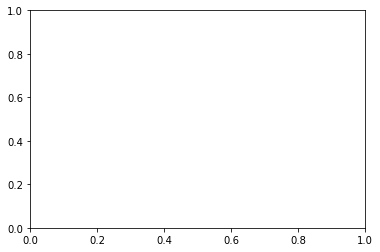

In [37]:
plt.plot(tdeath_values,dxy_values)

In [35]:
# df=df_fk
# c='C0'
# tavg2=14#ms
# SR_speed_align_thresh_min=0.0#cm^2/ms ~ 4*3  cm^2/s
# df=df_lr
c='C1'
tavg2=14#ms
SR_speed_align_thresh_min=0.02#cm^2/ms ~ 4*3  cm^2/s

# modname='msr_fk'
modname='msr_lr'

tmax=8#ms
# tmax=1e3#ms

SR_speed_align_thresh_max=.12#cm^2/ms  ~ 4*18 cm^2/s
tshift_align_thresh_min=-2.5#ms
tshift_align_thresh_max=2.5#ms
Rfinal_thresh=0.4#cm

# #to recompute savgol filtered values,
# #get time step
# tdeath_values_avail=df.sort_values(by='tdeath')['tdeath'].drop_duplicates().values
# # DT=np.around(np.median(np.diff(tdeath_values_avail)),7)

# trial_col='event_id_int'
#compute savgol window
navg2=np.int64(np.around(tavg2/DT))
navg2=navg2+1 if navg2%2==0 else navg2
# navg2=5

In [36]:
savgol_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=1,
    delta=1.0,
    axis=-1,
    mode='interp'
)

savgol0_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=0,
    delta=1.0,
    axis=-1,
    mode='interp'
)


<function scipy.signal._savitzky_golay.savgol_filter(x, window_length, polyorder, deriv=0, delta=1.0, axis=-1, mode='interp', cval=0.0)>

In [ ]:
xy

In [ ]:
R_col='R_nosavgol'
#TODO: extract the R_values and tdeath_values
tdeath_values=g['tdeath'].values
SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
#         R_values=g['R_nosavgol'].values
#dt=np.median(np.diff(tdeath_values))
#perform ols least squares on the final 8 values
y=SR_values[:8]
x=tdeath_values[:8]
dict_ols=compute_95CI_ols(x,y)

m=dict_ols['m']
Delta_SR_speed_align=dict_ols['Delta_m']

#compute the time shift
tf=x[0]
tshift_align=float(tf+dict_ols['b']/m)

#record
SR_speed_align_lst.append(m)
Delta_SR_speed_align_lst.append(Delta_SR_speed_align)

#         # TODO: compute_dRdt via finite difference
#         dSRdt_values=np.diff(SR_values)/DT*1e3
#         # TODO: compute speed_align... is it speed_align=first deriv from savgol filtered trajectories
#         SR_speed_align=dSRdt_values[0]
#         #is speed_align the first finite difference of the R_values?
#         SRfinal=SR_values[0]
#         #the moving average of speed is computed using the savitzgy golay filtration (best linear unbiased estimator)
#         tshift_align=float(speed_align/Rfinal/1e3)
#compute tdeath_align from tdeath and the moving average of speed
#tshift trajectories by that value
g['tdeath_align']=g['tdeath_align']+tshift_align
df_Ri.loc[group_name,'tdeath_align']=df_Ri.loc[group_name,'tdeath_align']+tshift_align
#return this over all particles, keep track of the shift amount
tshift_align_lst.append(tshift_align)
#         speed_align_lst.append(speed_align)
group_name_lst.append(group_name)


# make it simpler on yourself...

In [40]:
# #mean squared ranges
# msr_dir_fk="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00_msr.csv"
# msr_dir_lr="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00_msr.csv"

In [41]:
# df=pd.read_csv(msr_dir_lr)
# df.head()

,tdeath,avg,stderror,sqavg,sqstderror,counts
0,0.0,0.240091,0.004981,0.186144,0.009837,5181
1,0.5,0.281569,0.004864,0.201838,0.009837,5181
2,1.0,0.316478,0.004808,0.219906,0.009889,5181
3,1.5,0.342197,0.004730,0.232991,0.009922,5181
4,2.0,0.365405,0.004740,0.249909,0.010227,5181


In [ ]:
#TODO: group by event_id_int
#TODO: select the last remaining annihilation event
#TODO: compute the last remaining

# DONE: dev alignment routine for MSR results for the full models
- DONE: bubbled relevant parameters up
- TODO: port alignment routine to care and simplify it to a function that returns msr_csv_dir

In [43]:
##########################
# Compute MSR
##########################
R_col='R_nosavgol'
# R_col='R'
#load cached data
#FK at 0.4ms
#LR at 0.5ms
# data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_4.0_tavg2_14.00.csv'
# data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_4.0_tavg2_14.00.csv'
data_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_fk_tavg1_0.0_tavg2_14.00.csv'
data_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/annihilation_data_lr_tavg1_0.0_tavg2_14.00.csv'
df_fk=pd.read_csv(data_dir_fk)
df_lr=pd.read_csv(data_dir_lr)

# # print(len(save_dir_lst2))
# # print(save_dir_lst2[0])
# print(df_fk.head(2))
# print(df_lr.head(2))
#include memory preallocation 
df_fk['tdeath_align']=df_fk['tdeath'].copy()
df_lr['tdeath_align']=df_lr['tdeath'].copy()
#TODO: dev alignment routine to shift R_col and tdeath s.t. at time t=0, R=0, via linear interpolation of the at least the first two data points1

In [44]:
# df=df_fk
# c='C0'
# tavg2=14#ms
# SR_speed_align_thresh_min=0.0#cm^2/ms ~ 4*3  cm^2/s
# modname='msr_fk'
# tmax=1e3#ms

df=df_lr
c='C1'
tavg2=14#ms
SR_speed_align_thresh_min=0.02#cm^2/ms ~ 4*3  cm^2/s
modname='msr_lr'
tmax=8#ms

SR_speed_align_thresh_max=.12#cm^2/ms  ~ 4*18 cm^2/s
tshift_align_thresh_min=-2.5#ms
tshift_align_thresh_max=2.5#ms
Rfinal_thresh=0.4#cm

#to recompute savgol filtered values,
#get time step
tdeath_values_avail=df.sort_values(by='tdeath')['tdeath'].drop_duplicates().values
DT=np.around(np.median(np.diff(tdeath_values_avail)),7)

trial_col='event_id_int'
#compute savgol window
navg2=np.int64(np.around(tavg2/DT))
navg2=navg2+1 if navg2%2==0 else navg2
# navg2=5

In [45]:
savgol_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=1,
    delta=1.0,
    axis=-1,
    mode='interp'
)

savgol0_kwargs=dict(
    window_length=navg2,
    polyorder=3,
    deriv=0,
    delta=1.0,
    axis=-1,
    mode='interp'
)

In [46]:
# #recompute savgol filtered values
#<30second runtime roughly
# trial_col='event_id_int'
#isolate only the columns relevant to computing the attraction coefficient, a
# df_R=df_traj[[trial_col,'pid_self','pid_other','tdeath','R_nosavgol']].dropna()
df_R=df.sort_values([trial_col,'pid_self','pid_other','tdeath'], ascending=True)#.copy()

#compute the smoothed derivative savgol_filter using scipy's cryptic cython code
grouped=df_R.groupby([trial_col,'pid_self','pid_other'])
# grouped=df_R.to_pandas().groupby([trial_col,'pid_self','pid_other'])
result = grouped['R'].apply(savgol_filter,**savgol_kwargs)
dRdt_values=np.concatenate(result.values)
df_R['dRdt']=dRdt_values/DT*1000 #cm/s

#compute the smoothed value savgol_filter using scipy's cryptic cython code
grouped=df_R.groupby([trial_col,'pid_self','pid_other'])
# grouped=df_R.to_pandas().groupby([trial_col,'pid_self','pid_other'])
result = grouped['R'].apply(savgol_filter,**savgol0_kwargs)
R_values=np.array(np.concatenate(result.values))
df_R['R']=R_values

In [47]:
#TODO: remove anything that ends more than half a centimeter away
#TODO: test/verify that the time shift is actually employed on the LR MSR timeseries

In [48]:
# # tshift_tare_routine ALREADY DONE BELOW
# #perform tshift_tare_routine for all values...
# # df_R.set_index(['event_id_int','pid_self','pid_other'])
# retval=tshift_tare_routine(df_R,navg2)#,max_num_groups=9e9,npartitions=None,R_col='R_nosavgol',printing=True,**kwargs)
df_R[['tdeath','tdeath_align']].head()

,tdeath,tdeath_align
377856,0.0,0.0
377855,0.5,0.5
377854,1.0,1.0
377853,1.5,1.5
377852,2.0,2.0


In [55]:
#compute time shifts for the first x groups
# max_num_groups=3#9e9
#include memory preallocation 
# plotting=True
df_R['tdeath_align']=df_R['tdeath'].copy()
#group dataframe by annihilation event
# groups=df_R.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
groups=df_R.groupby(['event_id_int','pid_self','pid_other'])
df_Ri=df_R.set_index(['event_id_int','pid_self','pid_other'])

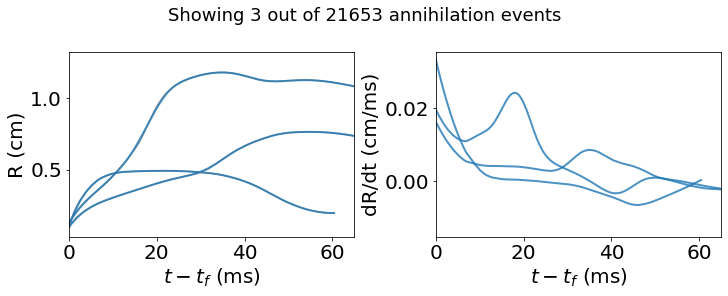

In [28]:
# #compute time shifts for the first x groups
# max_num_groups=3#9e9
# #include memory preallocation 
# plotting=True
# df_R['tdeath_align']=df_R['tdeath'].copy()
# #group dataframe by annihilation event
# # groups=df_R.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
# groups=df_R.groupby(['event_id_int','pid_self','pid_other'])
# df_Ri=df_R.set_index(['event_id_int','pid_self','pid_other'])
# if plotting:
#     plot_kwargs=dict(c='gray',alpha=0.8)
#     fig, axs=plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
#     format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel='R (cm)')#,xlim=[0,65])
#     format_plot(ax=axs[1],xlabel=r'$t-t_f$ (ms)',ylabel='dR/dt (cm/ms)')#,xlim=[0,65])
#     axs[0].set_xlim([0,65])
#     axs[1].set_xlim([0,65])
# # groups=df_fk.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
# tshift_align_lst=[]
# # speed_align_lst=[]
# group_name_lst=[]
# SR_speed_align_lst=[]
# Delta_SR_speed_align_lst=[]
# count=0
# for group_name,g in groups:
#     count+=1
#     if max_num_groups>=count:
#         #TODO: compute tshift_align
#         # R_col='R'
#         R_col='R_nosavgol'
#         #TODO: extract the R_values and tdeath_values
#         tdeath_values=g['tdeath'].values
#         SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
# #         R_values=g['R_nosavgol'].values
#         #dt=np.median(np.diff(tdeath_values))
#         #perform ols least squares on the final 8 values
#         y=SR_values[:8]
#         x=tdeath_values[:8]
#         dict_ols=compute_95CI_ols(x,y)
        
#         m=dict_ols['m']
#         Delta_SR_speed_align=dict_ols['Delta_m']
        
#         #compute the time shift
#         tf=x[0]
#         tshift_align=float(tf+dict_ols['b']/m)
        
#         #record
#         SR_speed_align_lst.append(m)
#         Delta_SR_speed_align_lst.append(Delta_SR_speed_align)
        
#         #         # TODO: compute_dRdt via finite difference
#         #         dSRdt_values=np.diff(SR_values)/DT*1e3
#         #         # TODO: compute speed_align... is it speed_align=first deriv from savgol filtered trajectories
#         #         SR_speed_align=dSRdt_values[0]
#         #         #is speed_align the first finite difference of the R_values?
#         #         SRfinal=SR_values[0]
#         #         #the moving average of speed is computed using the savitzgy golay filtration (best linear unbiased estimator)
#         #         tshift_align=float(speed_align/Rfinal/1e3)
#         #compute tdeath_align from tdeath and the moving average of speed
#         #tshift trajectories by that value
#         g['tdeath_align']=g['tdeath_align']+tshift_align
#         df_Ri.loc[group_name,'tdeath_align']=df_Ri.loc[group_name,'tdeath_align']+tshift_align
#         #return this over all particles, keep track of the shift amount
#         tshift_align_lst.append(tshift_align)
# #         speed_align_lst.append(speed_align)
#         group_name_lst.append(group_name)
        
#         if plotting:
#             #plot the results for this group
#             ax=axs[0]
#             ax.plot(tdeath_values,g['R_nosavgol'].values,label='Unfiltered',**plot_kwargs)
#             ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs),label='Sav-Gol Filtered',c=c,lw=2,alpha=0.8)
#             #         ax.plot(tdeath_values,g['R'],label='Sav-Gol Filtered',c='C0',lw=2,alpha=0.8)
#             ax=axs[1]
#             #         ax.plot(tdeath_values,g['dRdt'].values,**plot_kwargs)
#             ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol_kwargs),c=c,lw=2,alpha=0.8)
#             #         ax.plot(tdeath_values[1:],dRdt_values,c='C0',lw=2,alpha=0.8,**plot_kwargs)

# if plotting:
#     fig.suptitle(f"Showing {max_num_groups} out of {count} annihilation events\n",fontsize=18)
#     plt.show()

In [51]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [52]:
with HiddenPrints():
    retval=tshift_tare_routine(df_R,navg2,max_num_groups=9e9,plotting=False,npartitions=10,R_col='R_nosavgol',printing=True)
    # retval=tshift_tare_routine(df_R,navg2,max_num_groups=100,plotting=False,npartitions=10,R_col='R_nosavgol',printing=True)
    len(retval)

5181

In [31]:
# tshift_tare_routine
# retval


In [53]:
for rv in retval:
    if rv[:len("Warning:")+1]=="Warning:":
        print(rv)
rv

(1.2101972064183222,
 (1019316000, 8450, 8451),
 0.018342730301636297,
 0.0003261485908274107)

In [56]:
#record shifts to time as field tdeath_align
for rv in retval:
    tshift_align,group_name,SR_speed_align,Delta_SR_speed_align=rv
    df_Ri.loc[group_name,'tdeath_align']=df_Ri.loc[group_name,'tdeath']+tshift_align

/home/timothytyree/anaconda3/envs/pyenv_ub/lib/python3.7/site-packages/pandas/core/indexing.py:889: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/timothytyree/anaconda3/envs/pyenv_ub/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2899: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/timothytyree/anaconda3/envs/pyenv_ub/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [57]:
print(f"is tdeath different from tdeath_align?")
df_Ri[['tdeath','tdeath_align']].head()

is tdeath different from tdeath_align?


,,,tdeath,tdeath_align
event_id_int,pid_self,pid_other,,
1001116000,511,515,0.0,1.611570
1017226000,3291,3268,0.0,1.401188
1009236000,8784,8776,0.0,1.197864
1017226000,3270,3269,0.0,0.612754
1009236000,8856,8835,0.0,0.578115


,,,index,t,R,index_pairs,index_self,index_other,x_self,y_self,x_other,y_other,R_nosavgol,tdeath,tdeath_align,dRdt
event_id_int,pid_self,pid_other,,,,,,,,,,,,,,
1001116000,511,515,1088,1357.0,0.566352,6,14770,14776,142.048272,10.035969,143.214271,7.139896,0.078050,0.0,1.611570,-21.274696
1017226000,3291,3268,2510,5636.5,0.412828,17,108510,108509,73.022469,171.460421,74.473569,168.287983,0.087214,0.0,1.401188,28.593454
1009236000,8784,8776,5812,15759.0,0.963721,42,283721,283715,103.141463,129.104987,92.205360,123.118950,0.311680,0.0,1.197864,-12.400090
1017226000,3270,3269,1820,5562.0,0.207084,11,106833,106831,87.110736,70.680535,90.651457,68.260527,0.107218,0.0,0.612754,25.471119
1009236000,8856,8835,10407,15866.0,0.521943,80,286674,286675,15.913032,19.882036,12.389301,19.264657,0.089435,0.0,0.578115,40.376491


In [63]:
#heretim 
#TODO: choose rv in retval only if the group is the last remaining pair of spiral tips
# SR_speed_align_thresh_max=.12#cm^2/ms  ~ 4*18 cm^2/s
# tshift_align_thresh_min=-2.5#ms
# tshift_align_thresh_max=2.5#ms
#filter unreasonable outliers
#perform explicit transpose via for loop
# groups=df_fk.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
tshift_align_lst=[]
group_name_lst=[]
SR_speed_align_lst=[]
Delta_SR_speed_align_lst=[]
for rv in retval:
    tshift_align,group_name,SR_speed_align,Delta_SR_speed_align=rv
    boo=(SR_speed_align>=SR_speed_align_thresh_min) and (SR_speed_align<=SR_speed_align_thresh_max)
    boo&=(tshift_align>=tshift_align_thresh_min) and (tshift_align<=tshift_align_thresh_max)
    if boo:
        tshift_align_lst.append(tshift_align)
        group_name_lst.append(group_name)
        SR_speed_align_lst.append(SR_speed_align)
        Delta_SR_speed_align_lst.append(Delta_SR_speed_align)

dict_out={
'tshift_align':tshift_align_lst,
'group_name':group_name_lst,
'SR_speed_align':SR_speed_align_lst,
'Delta_SR_speed_align':Delta_SR_speed_align_lst
}
df_out=pd.DataFrame(dict_out)
# boo=df_out['SR_speed_align']>SR_speed_align_thresh
df_out.head()

,tshift_align,group_name,SR_speed_align,Delta_SR_speed_align
0,2.383693,"(1001116000, 809, 793)",0.021018,0.000053
1,1.307332,"(1001116000, 1473, 1468)",0.055310,0.000655
2,0.767075,"(1001116000, 1641, 1649)",0.028694,0.001596
3,0.765704,"(1001116000, 1694, 1703)",0.036308,0.002962
4,1.026697,"(1001116000, 1732, 1725)",0.030007,0.001449


In [64]:
#         if plotting:
#             #plot the results for this group
#             ax=axs[0]
#             ax.plot(tdeath_values,g['R_nosavgol'].values,label='Unfiltered',**plot_kwargs)
#             ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs),label='Sav-Gol Filtered',c=c,lw=2,alpha=0.8)
#             #         ax.plot(tdeath_values,g['R'],label='Sav-Gol Filtered',c='C0',lw=2,alpha=0.8)
#             ax=axs[1]
#             #         ax.plot(tdeath_values,g['dRdt'].values,**plot_kwargs)
#             ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol_kwargs),c=c,lw=2,alpha=0.8)
#             #         ax.plot(tdeath_values[1:],dRdt_values,c='C0',lw=2,alpha=0.8,**plot_kwargs)
    
# plotting=False 
# if plotting:
#     plot_kwargs=dict(c='gray',alpha=0.8)
#     fig, axs=plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
#     format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel='R (cm)')#,xlim=[0,65])
#     format_plot(ax=axs[1],xlabel=r'$t-t_f$ (ms)',ylabel='dR/dt (cm/ms)')#,xlim=[0,65])
#     axs[0].set_xlim([0,65])
#     axs[1].set_xlim([0,65])
    
#     #TODO: plot any desired trajectories

#     fig.suptitle(f"Showing {max_num_groups} out of {count} annihilation events\n",fontsize=18)
#     plt.show()ii

In [65]:
# #GOAL: use time binned bootstrap
# #NOTE: old method of boostrapping (synchronous tdeath values) no longer is valid!  I must instead use time binned bootstrap
# # #TODO: bootstrap squared range using time bins of bin_width = np.mean(tshift_align_lst)
# bin_width=np.mean(tshift_align_lst)
# bin_width


In [66]:
# for t_align,group_name in zip(tshift_align_lst,group_name_lst):
#     pass
# df_Ri.head()

/home/timothytyree/anaconda3/envs/pyenv_ub/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  This is separate from the ipykernel package so we can avoid doing imports until


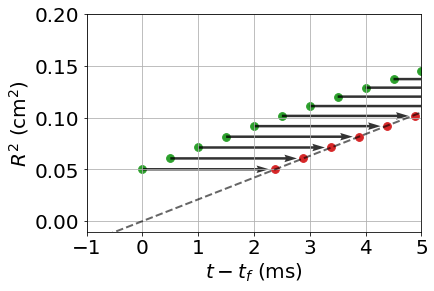

In [67]:
# for group_name in group_name_lst[:2]:
group_name=group_name_lst[0]
g=df_Ri.loc[group_name]
g.head()

x1_values=g['tdeath'].values
x2_values=g['tdeath_align'].values
y_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2 #cm^2


xmin,xmax=-1,5
#plot a black dotted line and show that it goes through zero
dict_ols=compute_95CI_ols(x2_values[:3],y_values[:3])
# dict_ols=compute_95CI_ols(x2_values[:8],y_values[:8])
xv=np.linspace(xmin,xmax,100)
plt.plot(xv,dict_ols['m']*xv+dict_ols['b'],'k--',alpha=0.6,lw=2)
#plot the data showing the linear transform
plt.scatter(x1_values,y_values,c='C2',s=60)
plt.scatter(x2_values,y_values,c='C3',s=60)
for x,y,u,v in zip(x1_values,y_values,x2_values-x1_values,y_values-y_values):
    plt.quiver(x,y,u,v,angles='xy', scale_units='xy', scale = 1.05, alpha=0.8,color='k')#, 0.*y_values)#, **kw)


# plt.quiver([x1_values,y_values], [x2_values,y_values],angles='xy', scale_units='xy', scale = 1)#, 0.*y_values)#, **kw)
format_plot(ax=plt.gca(),xlabel=r'$t-t_f$ (ms)',ylabel=r'$R^2$ (cm$^2$)')#,xlim=[0,65])
plt.xlim([xmin,xmax])
plt.ylim([-0.01,0.2])

# plt.quiver(0,0, 1, 1,angles='xy', scale_units='xy', scale = 1)
plt.xticks(range(-1,6))
# plt.yticks(range(-1,6))
plt.grid()
plt.draw()
plt.show()

In [68]:
# x1_values.shape,y_values.shape
np.quantile(SR_speed_align_lst,0.5)

0.0274450186335891

In [69]:
#rough estimate for a_sr
np.mean(np.array(SR_speed_align_lst)*1e3)/4,np.mean(np.array(SR_speed_align_lst))

(8.224751494219252, 0.032899005976877005)

In [70]:
# #GOAL: use time binned bootstrap
# #NOTE: old method of boostrapping (synchronous tdeath values) no longer is valid!  I must instead use time binned bootstrap
# #TODO: bootstrap squared range using time bins of bin_width = np.mean(tshift_align_lst)
# bin_width=np.mean(tshift_align_lst)
# bin_width

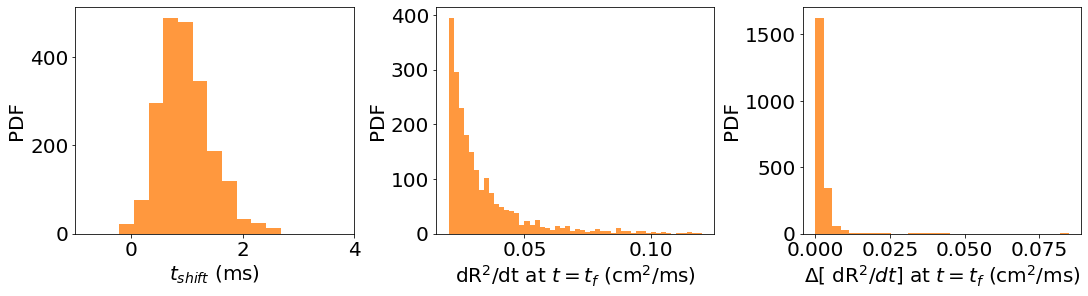

len(tshift_align_lst)=2084, len(SR_speed_align_lst)=2084, len(Delta_SR_speed_align_lst)=2084
estimate for a_sr at tf
8.224751494219252


In [71]:
# SR_speed_align_thresh=
fig,axs=plt.subplots(ncols=3,figsize=(15,4),constrained_layout=True)
axs[0].hist(tshift_align_lst,bins=np.linspace(-1,4,20),color=c,alpha=0.8)
format_plot(ax=axs[0],xlabel=r'$t_{shift}$ (ms)',ylabel='PDF')
axs[0].set_xlim([-1,4])
axs[1].hist(SR_speed_align_lst,bins=50,color=c,alpha=0.8)
format_plot(ax=axs[1],xlabel=r'dR$^2$/dt at $t=t_f$ (cm$^2$/ms)',ylabel='PDF')
axs[2].hist(Delta_SR_speed_align_lst,bins=30,color=c,alpha=0.8)
format_plot(ax=axs[2],xlabel=r'$\Delta[$ dR$^2/dt]$ at $t=t_f$ (cm$^2$/ms)',ylabel='PDF')
plt.show()
print(f"len(tshift_align_lst)={len(tshift_align_lst)}, len(SR_speed_align_lst)={len(SR_speed_align_lst)}, len(Delta_SR_speed_align_lst)={len(Delta_SR_speed_align_lst)}")
print(f"estimate for a_sr at tf")
print(np.mean(np.array(SR_speed_align_lst)*1e3)/4)

# print("""
# SR_speed_align_thresh_max=.12#cm^2/ms  ~ 4*18 cm^2/s
# SR_speed_align_thresh_min=0.02#cm^2/ms ~ 4*3  cm^2/s
# tshift_align_thresh_min=-2.5#ms
# tshift_align_thresh_max=2.5#ms
# """)

In [74]:
# df_Ri[['tdeath','tdeath_align']].head()

In [75]:
# df_out

In [76]:
# len(group_name_lst)

In [ ]:
# #visualize time shifts for the first x groups
# max_num_groups=15#9e9
# lw=2
# alpha=0.6
# #memory preallocation 
# plotting=True
# #group dataframe by annihilation event
# # groups=df_Ri.groupby(['event_id_int','pid_self','pid_other'])
# if plotting:
#     plot_kwargs=dict(c='gray',alpha=0.8)
#     fig, axs=plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
#     format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel='R (cm)')#,xlim=[0,65])
#     format_plot(ax=axs[1],xlabel=r'$t-t_f$ (ms)',ylabel='dR/dt (cm/ms)')#,xlim=[0,65])
#     axs[0].set_xlim([0,65])
#     axs[1].set_xlim([0,65])

# count=0
# # for group_name,g in groups:
# for group_name in group_name_lst:
#     g=df_Ri.loc[group_name]
#     count+=1
#     if max_num_groups>=count:
#         tdeath_values=g['tdeath'].values
#         #tdeath_values=g['tdeath_align'].values
#         if plotting:
#             #plot the results for this group
#             ax=axs[0]
#             ax.plot(tdeath_values,g['R_nosavgol'].values,label='Unfiltered',**plot_kwargs)
#             ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs),label='Sav-Gol Filtered',c=c,lw=lw,alpha=alpha)
#             #         ax.plot(tdeath_values,g['R'],label='Sav-Gol Filtered',c='C0',lw=2,alpha=0.8)
#             ax=axs[1]
#             #         ax.plot(tdeath_values,g['dRdt'].values,**plot_kwargs)
#             ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol_kwargs),c=c,lw=lw,alpha=alpha)
#             #         ax.plot(tdeath_values[1:],dRdt_values,c='C0',lw=2,alpha=0.8,**plot_kwargs)

# if plotting:
#     fig.suptitle(f"Showing {max_num_groups} out of {count} annihilation events\n",fontsize=18)
#     plt.show()

In [ ]:
# Rfinal_thresh=0.4#cm
# tshift_align_thresh=3#ms

In [ ]:
# #visualize time shifts for the first x groups
# max_num_groups=3#9e9
# lw=2
# alpha=0.6
# Rfinal_thresh=0.8#cm
# #memory preallocation 
# plotting=True
# #group dataframe by annihilation event
# # groups=df_Ri.groupby(['event_id_int','pid_self','pid_other'])
# if plotting:
#     plot_kwargs=dict(c='gray',alpha=0.8)
#     fig, axs=plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
# #     format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel=r'R$^2$ (cm$^2$)')#,xlim=[0,65])
#     format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel='R (cm)')#,xlim=[0,65])
#     format_plot(ax=axs[1],xlabel=r'$t-t_f$ (ms)',ylabel='dR/dt (cm/ms)')#,xlim=[0,65])
#     axs[0].set_xlim([0,65])
#     axs[0].set_ylim([0,2])
#     axs[1].set_xlim([0,65])

# count=0
# # tdeath_lst=[]
# # SR_lst=[]
# # for group_name,g in groups:
# for tshift_align,group_name in zip(tshift_align_lst,group_name_lst):
#     g=df_Ri.loc[group_name]
#     count+=1
#     if max_num_groups>=count:
#         #tdeath_values=g['tdeath'].values
        
        
#         #select values that end further than Q away
#         #heretim?
#         #Rfinal=np.min(g['R_nosavgol'].values[0])
#         Rfinal=g['R_nosavgol'].values[0]
#         boo=Rfinal<=Rfinal_thresh
#         boo&=np.abs(tshift_align)<tshift_align_thresh
#         if boo:
#             tdeath_values=g['tdeath_align'].values
#             SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)#**2
# #             tdeath_lst.extend(tdeath_values)
# #             SR_lst.extend(SR_values)
#             if plotting:
#                 #plot the results for this group
#                 ax=axs[0]
#                 #ax.plot(tdeath_values,g['R_nosavgol'].values,label='Unfiltered',**plot_kwargs)
#                 ax.plot(tdeath_values,SR_values,label='Sav-Gol Filtered',c=c,lw=lw,alpha=alpha)
#                 #         ax.plot(tdeath_values,g['R'],label='Sav-Gol Filtered',c='C0',lw=2,alpha=0.8)
#                 ax=axs[1]
#                 #         ax.plot(tdeath_values,g['dRdt'].values,**plot_kwargs)
#                 ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol_kwargs),c=c,lw=lw,alpha=alpha)
#                 #         ax.plot(tdeath_values[1:],dRdt_values,c='C0',lw=2,alpha=0.8,**plot_kwargs)

# if plotting:
#     fig.suptitle(f"Showing {max_num_groups} out of {count} annihilation events\n",fontsize=18)
#     plt.show()

In [77]:
lw=2
alpha=0.09

In [ ]:

# #visualize time shifts for the first x groups
# max_num_groups=100#9e9
# lw=2
# alpha=0.09
# Rfinal_thresh=0.8#cm
# #memory preallocation 
# plotting=True
# #group dataframe by annihilation event
# # groups=df_Ri.groupby(['event_id_int','pid_self','pid_other'])
# if plotting:
#     plot_kwargs=dict(c='gray',alpha=0.8)
#     fig, axs=plt.subplots(ncols=2,figsize=(10,4),constrained_layout=True)
#     format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel=r'R$^2$ (cm$^2$)')#,xlim=[0,65])
#     #format_plot(ax=axs[0],xlabel=r'$t-t_f$ (ms)',ylabel='R (cm)')#,xlim=[0,65])
#     format_plot(ax=axs[1],xlabel=r'$t-t_f$ (ms)',ylabel='dR/dt (cm/ms)')#,xlim=[0,65])
#     axs[0].set_xlim([0,65])
#     axs[0].set_ylim([0,2])
#     axs[1].set_xlim([0,65])

# count=0
# tdeath_lst=[]
# SR_lst=[]
# # for group_name,g in groups:
# for tshift_align,group_name in zip(tshift_align_lst,group_name_lst):
#     g=df_Ri.loc[group_name]
#     count+=1
#     if max_num_groups>=count:
#         #tdeath_values=g['tdeath'].values
        
        
#         #select values that end further than Q away
#         #heretim?
#         #Rfinal=np.min(g['R_nosavgol'].values[0])
#         Rfinal=g['R_nosavgol'].values[0]
#         boo=Rfinal<=Rfinal_thresh
#         boo&=np.abs(tshift_align)<tshift_align_thresh
#         if boo:
#             tdeath_values=g['tdeath_align'].values
#             SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
#             tdeath_lst.extend(tdeath_values)
#             SR_lst.extend(SR_values)
#             if plotting:
#                 #plot the results for this group
#                 ax=axs[0]
#                 #ax.plot(tdeath_values,g['R_nosavgol'].values,label='Unfiltered',**plot_kwargs)
#                 ax.plot(tdeath_values,SR_values,label='Sav-Gol Filtered',c=c,lw=lw,alpha=alpha)
#                 #         ax.plot(tdeath_values,g['R'],label='Sav-Gol Filtered',c='C0',lw=2,alpha=0.8)
#                 ax=axs[1]
#                 #         ax.plot(tdeath_values,g['dRdt'].values,**plot_kwargs)
#                 ax.plot(tdeath_values,savgol_filter(g['R_nosavgol'].values,**savgol_kwargs),c=c,lw=lw,alpha=alpha)
#                 #         ax.plot(tdeath_values[1:],dRdt_values,c='C0',lw=2,alpha=0.8,**plot_kwargs)

# if plotting:
#     fig.suptitle(f"Showing {max_num_groups} out of {count} annihilation events\n",fontsize=18)
#     plt.show()

In [78]:
#compute bootstrap input for all data available
#visualize time shifts for the first x groups
max_num_groups=len(group_name_lst)
Rfinal_thresh=0.4#cm
tshift_align_thresh=3#ms
#memory preallocation 

count=0
count_considered=0
tdeath_lst=[]
SR_lst=[]
# for group_name,g in groups:
for tshift_align,group_name in zip(tshift_align_lst,group_name_lst):
    g=df_Ri.loc[group_name]
    count+=1
    if max_num_groups>=count:
        #tdeath_values=g['tdeath'].values
        #select values that end further than Q away
        #heretim?
        #Rfinal=np.min(g['R_nosavgol'].values[0])
        Rfinal=g['R_nosavgol'].values[0]
        boo=Rfinal<=Rfinal_thresh
        boo&=np.abs(tshift_align)<tshift_align_thresh
        if boo:
            tdeath_values=g['tdeath_align'].values
            SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
            tdeath_lst.extend(tdeath_values)
            SR_lst.extend(SR_values)
            count_considered+=1

/home/timothytyree/anaconda3/envs/pyenv_ub/lib/python3.7/site-packages/ipykernel_launcher.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  


In [79]:
max_num_groups=count_considered
max_num_groups

2083

In [80]:
# #preallocate memory
# df_Ri['SR']=df_Ri['R_nosavgol']**2
# #TODO: bootstrap R^2, binning by tdeath_align
# for group_name,g in groups:
#     SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
#     event_id_int,pid_self,pid_other=group_name
#     #boo=(df_Ri['event_id_int']==event_id_int)& (df_Ri['pid_self']==pid_self)& (df_Ri['pid_other']==pid_other)
#     df_Ri.loc[group_name,'SR']=SR_values
    
# x_values=df_Ri['tdeath_align'].values
# y_values=df_Ri['SR'].values


In [81]:
print(f"navg2={navg2}")

navg2=29


In [82]:
#smooth R and then return SR for a given annihilation event
def routine(data):
    navg2_local=29
    group_name,R_values=data
    #to compute tshift_align,
    #     savgol_kwargs=dict(
    #             window_length=navg2_local,
    #             polyorder=3,
    #             deriv=1,
    #             delta=1.0,
    #             axis=-1,
    #             mode='interp')
    savgol0_kwargs=dict(
            window_length=navg2_local,
            polyorder=3,
            deriv=0,
            delta=1.0,
            axis=-1,
            mode='interp')
    SR_values=savgol_filter(R_values,**savgol0_kwargs)**2
    return SR_values
    #event_id_int,pid_self,pid_other=group_name
    #boo=(df_Ri['event_id_int']==event_id_int)& (df_Ri['pid_self']==pid_self)& (df_Ri['pid_other']==pid_other)

In [83]:
# #heretim
# boo_lst=[]
# #TODO: record ^that boo filter for large R values
# boo_lst.append(boo)
# #TODO: use ^that boo filter for large R values
# # df_Ri.index.values

In [84]:
#not working and seems to give the wrong answer by not removing the pairs with Rfinal>Rfinal_thresh
# #parallelize with dask.bag
# task_lst=[]
# for group_name,g in groups:
#     R_values=g['R_nosavgol'].values
#     task_lst.append((group_name,R_values))
# #color squared range field in parallelizable fashion
# #DONE: dask bag accelerate tshift_tare_routine
# printing=True
# npartitions=None
# if npartitions is None:
#     npartitions=os.cpu_count()
# #all CPU version
# b = db.from_sequence(task_lst, npartitions=npartitions).map(routine)

# #DONE: evaluate task_lst
# start = time.time()
# retval = list(b)
# SR_values_lst=retval
# #preallocate memory
# df_Ri['SR']=df_Ri['R_nosavgol'].copy()**2
# #up to here took 6.05 seconds...
# assert( len(SR_values_lst)==len(groups))
# for SR_values,(group_name,g) in zip(SR_values_lst,groups):
#     df_Ri.loc[group_name,'SR']=SR_values
# if printing:
#     print(f"run time aligning trajectories was {time.time()-start:.2f} seconds.")

In [85]:
# # heretim!
# # i want bootstrap to only have boo_values, where boo if (Rfinal<Rfinal_thresh)
# #include task in bootstrap if and only if boo
# boo_lst=[]
# for group_name,g in groups:
#     tdeath_values=g['tdeath_align'].values
#     #select values that end further than Q away
#     #heretim?
#     #Rfinal=np.min(g['R_nosavgol'].values[0])
#     R_values=g['R_nosavgol'].values
#     Rfinal=R_values[0]
#     boo=Rfinal<=Rfinal_thresh
#     boo=(Rfinal<Rfinal_thresh)
#     Rfinal_values=Rfinal+0.*R_values
#     boo=(Rfinal_values<Rfinal_thresh)
#     boo_lst.extend(boo)
# #     if boo:
# #         R_values=g['R_nosavgol'].values
# #         task_lst.append((group_name,R_values))
# boo_values=np.array(boo_lst)
# print(len(boo_lst))
# boo_lst

boo

In [86]:
# # x_values=df_Ri['tdeath_align'].values
# # y_values=df_Ri['SR'].values
# x_values=np.array(tdeath_lst)
# y_values=np.array(SR_lst)
# print(x_values)
# # # # TODO: test that SR_values_lst[0] is not the same as df_Ri.loc[group_name,'R_nosavgol']
# # # SR_values_lst[-1],df_Ri.loc[group_name,'R_nosavgol'].values**2
# # boo_values=np.array(boo_lst)
# # print(len(boo_lst))

this error would occur if df_Ri is not being updated with SR_values or tdeath_align correctly...   However, the y-intercept still is not x=0...

In [87]:
# x_values.shape,y_values.shape

In [88]:
# # # #DONE: bootstrap SR, binning by tdeath_align
# # df_Ri[['tdeath','tdeath_align']].head()
# x_values_in.shape
1

1

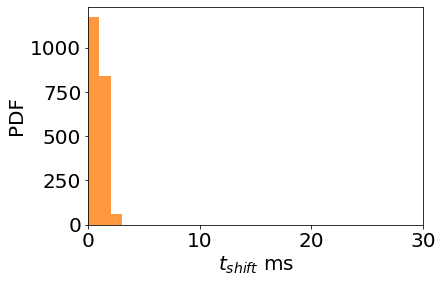

0.9750825942791341

In [89]:
plt.hist(tshift_align_lst,bins=np.arange(0,30,1),color=c,alpha=0.8)
plt.xlim(0,30)
format_plot(ax=plt.gca(),xlabel=r'$t_{shift}$ ms',ylabel=r'PDF')

plt.show()
np.mean(tshift_align_lst)

In [ ]:
#heretim 
#TODO: identify which events are the last event for that trial
# df_Ri.loc[boo_values,'tdeath_align'].values,

In [90]:
#compute bootstrap 
x_values_in=np.array(tdeath_lst)
y_values_in=np.array(SR_lst)
bins='auto'
# bins=np.arange(0,200,1)
# df_bootstrap=bin_and_bootstrap_xy_values_parallel(df_Ri.loc[boo_values,'tdeath_align'].values,
#                                df_Ri.loc[boo_values,'SR'].values,
df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,#df_Ri.loc[boo_values,'tdeath_align'].values,
                               y_values_in,#df_Ri.loc[boo_values,'SR'].values,
                               xlabel='tdeath_avg',
                               ylabel='MSR',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=1000,
                               npartitions=10,
                               use_test=False)
# print(type(retval))
df_bootstrap.head()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
0,0.650463,0.022884,0.011892,0.000716,0.638916,0.117630,1257
1,1.462849,0.049310,0.009214,0.000852,0.031585,0.148348,3857
2,2.458903,0.085675,0.009157,0.001454,0.816493,0.030565,4224
3,3.475242,0.125146,0.008925,0.002208,0.341298,0.164561,4244
4,4.494791,0.162889,0.008829,0.002729,0.053834,0.550636,4251


In [ ]:
#TODO: save df_Ri as csv if it has event_id_int still


In [ ]:
#DONE: limit xlim to 180ms
#TODO: step through and find where the tshift is getting missed (i.e. fix the LR model not intersecting zero).

In [91]:
x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

((119,), (119,), (119,))

In [92]:
1

1

Does this appear to intersect at zero?


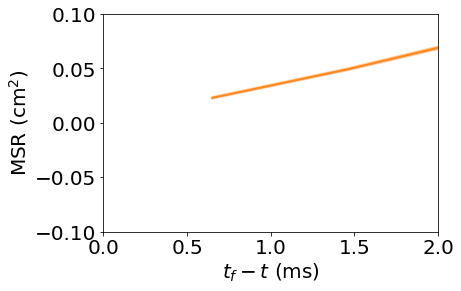

In [93]:
print(f"Does this appear to intersect at zero?")
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.xlim([0,2])
plt.ylim([-.1,.1])
plt.show()

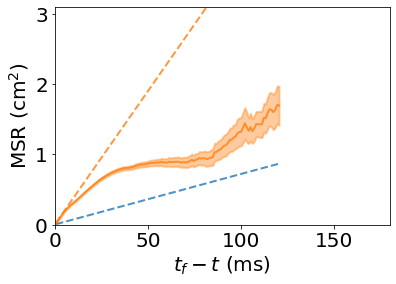

In [94]:
#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,180])
plt.ylim([0,3.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

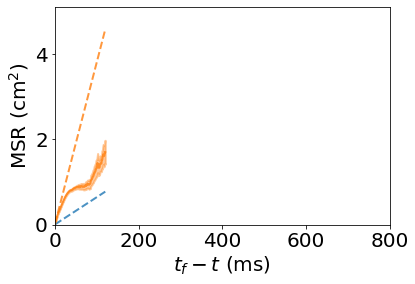

In [95]:
#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,4*1.6*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,800])
plt.ylim([0,5.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

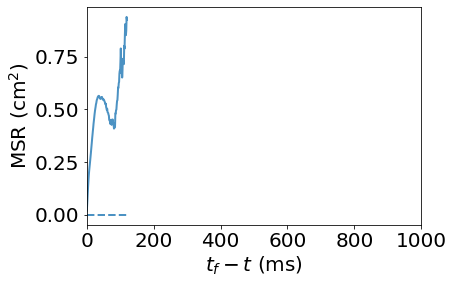

In [96]:
sig = y_values-4*1.6*1e-3*x_values
plt.plot(x_values,0*x_values,'--',lw=2,alpha=0.8,c='C0')
plt.plot(x_values,sig,lw=2,alpha=0.8,c='C0')

format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1000])
# plt.ylim([0,5.1])
plt.show()

In [97]:
from scipy import signal
from scipy.signal import argrelextrema

In [98]:
tmax=300

In [99]:
sig = y_values-4*1.6*1e-3*x_values
boo=x_values<tmax
DT=np.diff(x_values)[0]
sig=sig[boo].copy()
corr = signal.correlate(sig, sig)
lags = signal.correlation_lags(len(sig), len(sig))
corr /= np.max(corr)

In [100]:
# for local_maxima
local_maxima=argrelextrema(corr, np.greater)

# for local_minima
local_minima=argrelextrema(corr, np.less)

#TODO: find period of MSR before death
taumax_values=DT*lags[local_maxima]
taumin_values=DT*lags[local_minima]
np.diff(taumin_values),np.diff(taumax_values)

(array([], dtype=float64), array([], dtype=float64))

Periods of Autocorrelation of MSR (ms):
[]


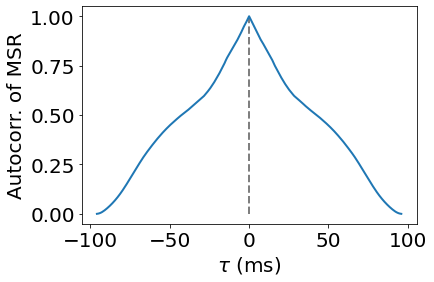

In [101]:
print(f"Periods of Autocorrelation of MSR (ms):")
print(np.diff(taumax_values))
yv=np.linspace(0,1,20)
for taumax in taumax_values:
    plt.plot(taumax+0.*yv,yv,'k--',alpha=0.5,lw=2)
    
plt.plot(DT*lags,corr,lw=2)
format_plot(ax=plt.gca(),xlabel=r'$\tau$ (ms)',ylabel=r'Autocorr. of MSR')
plt.show()

In [102]:
# # tmax=8#ms
# tmax=1e3#ms
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_SR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s")
print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

a_SR = 2.590625+/-0.143947 cm^2/s
tavg2=14 ms, num_samples=2083


In [103]:
#DONE: record ^this in .odg
#DONT: does R values have units of cm when it is saved?  maybe I'm missing a scale of 5/200???^2???
#DONE: repeat with all samples!
#TODO: repeat with more/less smoothingi
1

1

In [105]:
#save as .csv
# modname='msr_fk'
# # modname='msr_lr'
save_folder=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results"
os.listdir(save_folder)
msr_csv_fn=f"{modname}_boostrapped_tavg2_{tavg2:.1f}_n_{max_num_groups}_a_{a_SR:.1f}_tmax_{tmax}.csv"
msr_csv_dir=os.path.join(save_folder,msr_csv_fn)
df_bootstrap.to_csv(msr_csv_dir,index=False)
msr_csv_dir

'/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_2.6_tmax_300.csv'

In [106]:
beep(4)



0

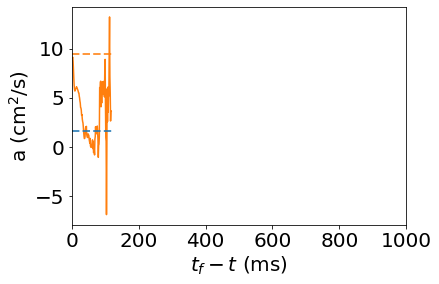

In [107]:
#plot a versus t_f-t using (i) finite diff and (ii) using savgol
xmid_values=0.5*(x_values[1:]+x_values[:-1])
dydx_values=np.diff(y_values)/np.diff(x_values)
xmid_values=moving_average(xmid_values,4)
dydx_values=moving_average(dydx_values,4)
plt.plot(xmid_values,dydx_values/4*1e3,c=c)

#plot expected
plt.plot(x_values,9.5+0.*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,1.6+0.*x_values,'--',lw=2,alpha=0.8,c='C0')

format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'a (cm$^2$/s)')
plt.xlim([0,1000])
plt.show()

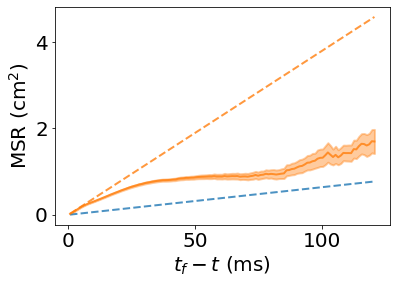

In [108]:
#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,4*1.6*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

In [109]:
beep(3)



0

In [110]:
#TODO: repeat for FK model

In [111]:
#TODO: save df_Ri
df_Ri.head()

,,,index,t,R,index_pairs,index_self,index_other,x_self,y_self,x_other,y_other,R_nosavgol,tdeath,tdeath_align,dRdt
event_id_int,pid_self,pid_other,,,,,,,,,,,,,,
1001116000,511,515,1088,1357.0,0.566352,6,14770,14776,142.048272,10.035969,143.214271,7.139896,0.078050,0.0,1.611570,-21.274696
1017226000,3291,3268,2510,5636.5,0.412828,17,108510,108509,73.022469,171.460421,74.473569,168.287983,0.087214,0.0,1.401188,28.593454
1009236000,8784,8776,5812,15759.0,0.963721,42,283721,283715,103.141463,129.104987,92.205360,123.118950,0.311680,0.0,1.197864,-12.400090
1017226000,3270,3269,1820,5562.0,0.207084,11,106833,106831,87.110736,70.680535,90.651457,68.260527,0.107218,0.0,0.612754,25.471119
1009236000,8856,8835,10407,15866.0,0.521943,80,286674,286675,15.913032,19.882036,12.389301,19.264657,0.089435,0.0,0.578115,40.376491


# TODO: select only the members of df_Ri that are the last remaining tips

In [135]:
dfRi=df_Ri.reset_index()
tmax_series=dfRi.groupby('event_id_int')['t'].max()
event_id_values=tmax_series.index.values
tmax_values=tmax_series.values
lastgroupname_lst=[]
for tmx,event_id in zip(tmax_series,event_id_values):
    #identify the pid pair that has this tmax 
    lastgroupname=dfRi.loc[(dfRi['event_id_int']==event_id)&(dfRi['t']==tmx),['event_id_int','pid_self','pid_other']].values[0]
    lastgroupname_lst.append(tuple(lastgroupname))

In [138]:
lastgroupname_set=set(lastgroupname_lst)
# lastgroupname_set

# TODO: copy everything after heretim below

In [139]:
#heretim 
#TODO: choose rv in retval only if the group is the last remaining pair of spiral tips
# SR_speed_align_thresh_max=.12#cm^2/ms  ~ 4*18 cm^2/s
# tshift_align_thresh_min=-2.5#ms
# tshift_align_thresh_max=2.5#ms
#filter unreasonable outliers
#perform explicit transpose via for loop
# groups=df_fk.sort_values('tdeath',ascending=True).groupby(['event_id_int','pid_self','pid_other'])
tshift_align_lst=[]
group_name_lst=[]
SR_speed_align_lst=[]
Delta_SR_speed_align_lst=[]
for rv in retval:
    tshift_align,group_name,SR_speed_align,Delta_SR_speed_align=rv
    boo=(SR_speed_align>=SR_speed_align_thresh_min) and (SR_speed_align<=SR_speed_align_thresh_max)
    boo&=(tshift_align>=tshift_align_thresh_min) and (tshift_align<=tshift_align_thresh_max)
    if boo:
        tshift_align_lst.append(tshift_align)
        group_name_lst.append(group_name)
        SR_speed_align_lst.append(SR_speed_align)
        Delta_SR_speed_align_lst.append(Delta_SR_speed_align)

dict_out={
'tshift_align':tshift_align_lst,
'group_name':group_name_lst,
'SR_speed_align':SR_speed_align_lst,
'Delta_SR_speed_align':Delta_SR_speed_align_lst
}
df_out=pd.DataFrame(dict_out)
# boo=df_out['SR_speed_align']>SR_speed_align_thresh
df_out.head()

,tshift_align,group_name,SR_speed_align,Delta_SR_speed_align
0,2.383693,"(1001116000, 809, 793)",0.021018,0.000053
1,1.307332,"(1001116000, 1473, 1468)",0.055310,0.000655
2,0.767075,"(1001116000, 1641, 1649)",0.028694,0.001596
3,0.765704,"(1001116000, 1694, 1703)",0.036308,0.002962
4,1.026697,"(1001116000, 1732, 1725)",0.030007,0.001449


In [141]:
# # for group_name in group_name_lst[:2]:
# group_name=group_name_lst[0]
# g=df_Ri.loc[group_name]
# g.head()

# x1_values=g['tdeath'].values
# x2_values=g['tdeath_align'].values
# y_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2 #cm^2


# xmin,xmax=-1,5
# #plot a black dotted line and show that it goes through zero
# dict_ols=compute_95CI_ols(x2_values[:3],y_values[:3])
# # dict_ols=compute_95CI_ols(x2_values[:8],y_values[:8])
# xv=np.linspace(xmin,xmax,100)
# plt.plot(xv,dict_ols['m']*xv+dict_ols['b'],'k--',alpha=0.6,lw=2)
# #plot the data showing the linear transform
# plt.scatter(x1_values,y_values,c='C2',s=60)
# plt.scatter(x2_values,y_values,c='C3',s=60)
# for x,y,u,v in zip(x1_values,y_values,x2_values-x1_values,y_values-y_values):
#     plt.quiver(x,y,u,v,angles='xy', scale_units='xy', scale = 1.05, alpha=0.8,color='k')#, 0.*y_values)#, **kw)


# # plt.quiver([x1_values,y_values], [x2_values,y_values],angles='xy', scale_units='xy', scale = 1)#, 0.*y_values)#, **kw)
# format_plot(ax=plt.gca(),xlabel=r'$t-t_f$ (ms)',ylabel=r'$R^2$ (cm$^2$)')#,xlim=[0,65])
# plt.xlim([xmin,xmax])
# plt.ylim([-0.01,0.2])

# # plt.quiver(0,0, 1, 1,angles='xy', scale_units='xy', scale = 1)
# plt.xticks(range(-1,6))
# # plt.yticks(range(-1,6))
# plt.grid()
# plt.draw()
# plt.show()
group_name

(1019316000, 8450, 8451)

In [142]:
#compute bootstrap input for all data available
#visualize time shifts for the first x groups
max_num_groups=len(group_name_lst)
Rfinal_thresh=0.4#cm
tshift_align_thresh=3#ms
#memory preallocation 

count=0
count_considered=0
tdeath_lst=[]
SR_lst=[]
# for group_name,g in groups:
for tshift_align,group_name in zip(tshift_align_lst,group_name_lst):
    g=df_Ri.loc[group_name]
    count+=1
    if max_num_groups>=count:
        #tdeath_values=g['tdeath'].values
        #select values that end further than Q away
        #heretim?
        #Rfinal=np.min(g['R_nosavgol'].values[0])
        Rfinal=g['R_nosavgol'].values[0]
        boo=Rfinal<=Rfinal_thresh
        boo&=np.abs(tshift_align)<tshift_align_thresh
        #include only if this is the last group for the trial
        boo&=lastgroupname_set.issuperset({group_name})
        if boo:
            tdeath_values=g['tdeath_align'].values
            SR_values=savgol_filter(g['R_nosavgol'].values,**savgol0_kwargs)**2
            tdeath_lst.extend(tdeath_values)
            SR_lst.extend(SR_values)
            count_considered+=1

/home/timothytyree/anaconda3/envs/pyenv_ub/lib/python3.7/site-packages/ipykernel_launcher.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  


In [143]:
max_num_groups=count_considered
max_num_groups

62

In [144]:
#compute bootstrap 
x_values_in=np.array(tdeath_lst)
y_values_in=np.array(SR_lst)
bins='auto'
# bins=np.arange(0,200,1)
# df_bootstrap=bin_and_bootstrap_xy_values_parallel(df_Ri.loc[boo_values,'tdeath_align'].values,
#                                df_Ri.loc[boo_values,'SR'].values,
df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,#df_Ri.loc[boo_values,'tdeath_align'].values,
                               y_values_in,#df_Ri.loc[boo_values,'SR'].values,
                               xlabel='tdeath_avg',
                               ylabel='MSR',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=1000,
                               npartitions=10,
                               use_test=False)
# print(type(retval))
df_bootstrap.head()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
0,1.786032,0.064243,0.084874,0.004494,0.355278,0.012345,290
1,4.465847,0.172717,0.089441,0.008726,0.063202,0.415813,366
2,7.429492,0.280234,0.088187,0.015777,0.321439,0.613728,369
3,10.409470,0.370196,0.087054,0.022696,0.201630,0.806211,370
4,13.393385,0.459338,0.088861,0.027124,0.238645,0.422587,370


In [145]:
x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

((31,), (31,), (31,))

In [163]:
tmax=24#ms
# tmax=8#ms
# tmax=1e3#ms
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_SR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s")
print(f"tavg2={tavg2} ms, num_samples={max_num_groups}, tmax={tmax:.1f}")

a_SR = 7.744351+/-0.388105 cm^2/s
tavg2=14 ms, num_samples=62, tmax=24.0


In [147]:
#save as .csv
# modname='msr_fk'
# # modname='msr_lr'
save_folder=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results"
os.listdir(save_folder)
msr_csv_fn=f"{modname}_boostrapped_tavg2_{tavg2:.1f}_n_{max_num_groups}_a_{a_SR:.1f}_tmax_{tmax}_final_only.csv"
msr_csv_dir=os.path.join(save_folder,msr_csv_fn)
df_bootstrap.to_csv(msr_csv_dir,index=False)
msr_csv_dir

'/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_62_a_3.2_tmax_300_final_only.csv'

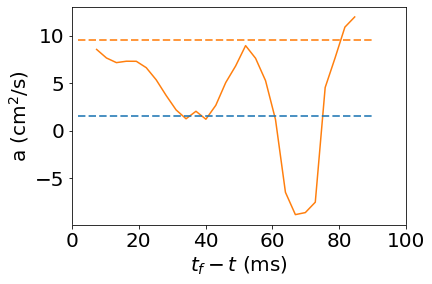

In [150]:
#plot a versus t_f-t using (i) finite diff and (ii) using savgol
xmid_values=0.5*(x_values[1:]+x_values[:-1])
dydx_values=np.diff(y_values)/np.diff(x_values)
xmid_values=moving_average(xmid_values,4)
dydx_values=moving_average(dydx_values,4)
plt.plot(xmid_values,dydx_values/4*1e3,c=c)

#plot expected
plt.plot(x_values,9.5+0.*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,1.6+0.*x_values,'--',lw=2,alpha=0.8,c='C0')

format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'a (cm$^2$/s)')
plt.xlim([0,100])
plt.show()

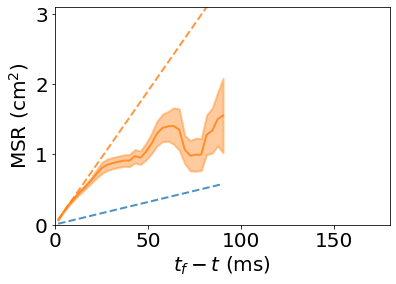

In [151]:
#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,4*1.6*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
plt.plot(x_values,np.sqrt(5)**2+0.*x_values,'--',lw=2,alpha=0.8,c='C0')

#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,180])
plt.ylim([0,3.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

2.23606797749979